# Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

In [2]:
df = pd.read_csv("../Dataset/dataset time series.csv")
df.head()

,TANGGAL,TN,TX,TAVG,RH_AVG,RR,SS,FF_X,DDD_X,FF_AVG,DDD_CAR
0,01-01-2020,24,29.6,26.3,88,23.5,3.4,6,280,2,C
1,02-01-2020,24.2,32.8,28.5,82,12.4,0.0,9,280,3,W
2,03-01-2020,25.8,32.0,28.2,82,0,8.3,12,300,5,NW
3,04-01-2020,26.2,31.6,28.3,82,0.4,5.8,8,300,5,W
4,05-01-2020,26.4,32.6,27.7,84,0.1,2.1,14,270,4,NW


# Data Wrangling

## 1. Penilain Data

In [3]:
df.describe()

,TX,TAVG,RH_AVG,SS,FF_X,DDD_X,FF_AVG
count,1887.000000,1887.000000,1887.00000,1887.000000,1887.000000,1887.000000,1887.000000
mean,32.078908,28.469687,80.45257,6.660996,7.403286,185.336513,2.361420
std,1.269501,1.108534,6.80323,3.352550,2.437566,85.456051,1.222689
min,26.200000,24.300000,59.00000,0.000000,0.000000,0.000000,0.000000
25%,31.400000,27.700000,76.00000,4.000000,6.000000,120.000000,1.000000
50%,32.000000,28.400000,81.00000,7.900000,7.000000,150.000000,2.000000
75%,32.800000,29.200000,86.00000,9.700000,9.000000,280.000000,3.000000
max,35.800000,32.100000,98.00000,11.700000,19.000000,360.000000,7.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1887 entries, 0 to 1886
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   TANGGAL  1887 non-null   object 
 1   TN       1887 non-null   object 
 2   TX       1887 non-null   float64
 3   TAVG     1887 non-null   float64
 4   RH_AVG   1887 non-null   int64  
 5   RR       1887 non-null   object 
 6   SS       1887 non-null   float64
 7   FF_X     1887 non-null   int64  
 8   DDD_X    1887 non-null   int64  
 9   FF_AVG   1887 non-null   int64  
 10  DDD_CAR  1887 non-null   object 
dtypes: float64(3), int64(4), object(4)
memory usage: 162.3+ KB


## Pembersihan Data

In [5]:
# Konversi semua kolom bertipe object ke numerik
for col in ["TN", "RR"]:
    df[col] = pd.to_numeric(df[col], errors='coerce') 

In [6]:
# Ganti nilai 8888 dan 9999 dengan None (NaN)
df = df.replace(({8888: np.nan, 9999: np.nan}))

In [7]:
# Menangani missing values dengan metode yang lebih baik
print("Missing values sebelum penanganan:")
print(df.isna().sum())

Missing values sebelum penanganan:
TANGGAL      0
TN           1
TX           0
TAVG         0
RH_AVG       0
RR         127
SS           0
FF_X         0
DDD_X        0
FF_AVG       0
DDD_CAR      0
dtype: int64


In [8]:
# Untuk kolom numerik, gunakan interpolasi untuk mengisi nilai yang hilang
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_cols:
    df[col] = df[col].interpolate(method='linear')

In [9]:
# Untuk kolom kategorik atau tanggal, gunakan ffill
df = df.ffill()

In [9]:
print("\nMissing values setelah penanganan:")
print(df.isna().sum())


Missing values setelah penanganan:
TANGGAL    0
TN         0
TX         0
TAVG       0
RH_AVG     0
RR         0
SS         0
FF_X       0
DDD_X      0
FF_AVG     0
DDD_CAR    0
dtype: int64


In [10]:
# Hapus kolom yang tidak diperlukan
df = df.drop(columns=["DDD_CAR", 'DDD_X'])

In [11]:
# Mengubah kolom 'TANGGAL' ke format datetime
df['TANGGAL'] = pd.to_datetime(df['TANGGAL'], format='%d-%m-%Y')

In [12]:
# Menambahkan Fitur Waktu yang Lebih Lengkap
df['Hari'] = df['TANGGAL'].dt.dayofweek
df['Bulan'] = df['TANGGAL'].dt.month
df['Tahun'] = df['TANGGAL'].dt.year
# df['Hari_Bulan'] = df['TANGGAL'].dt.day
# df['Kuartal'] = df['TANGGAL'].dt.quarter

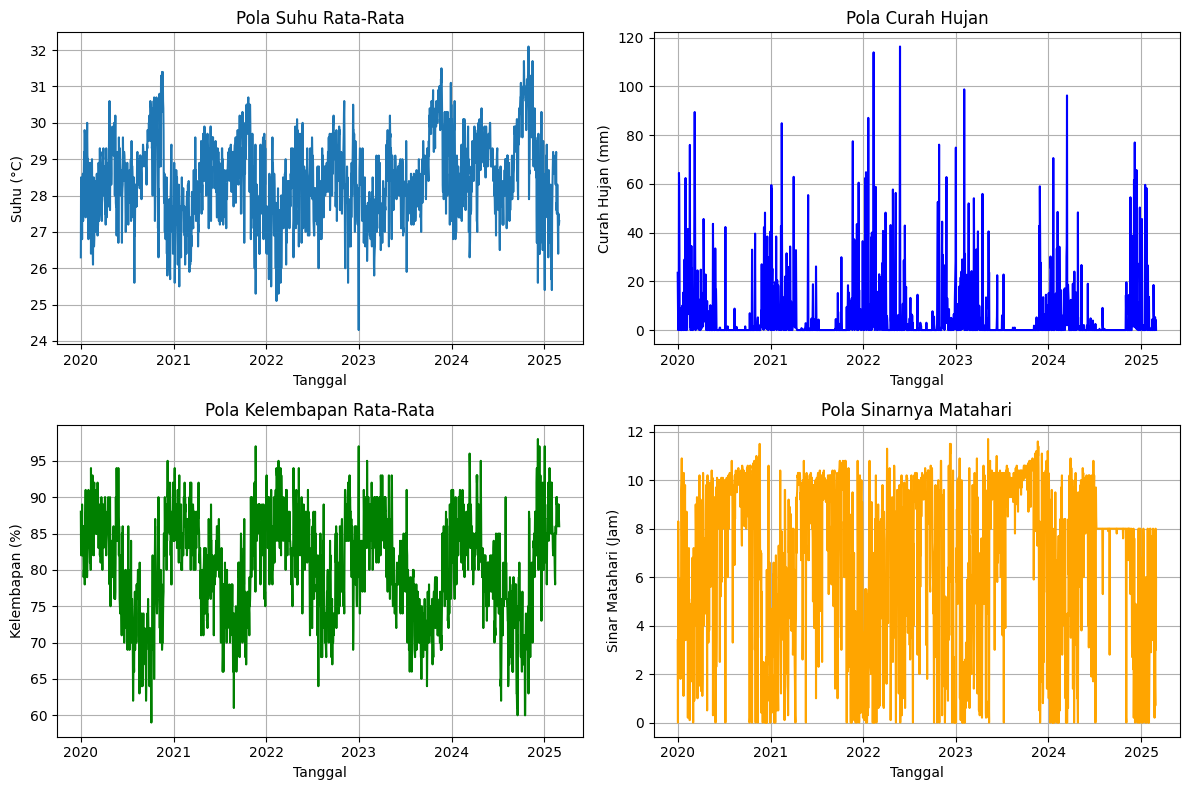

In [13]:
# Visualisasi Pola Cuaca
plt.figure(figsize=(12, 8))
# Suhu Rata-Rata
plt.subplot(2, 2, 1)
plt.plot(df['TANGGAL'], df['TAVG'], label='Suhu Rata-Rata')
plt.xlabel('Tanggal')
plt.ylabel('Suhu (°C)')
plt.title('Pola Suhu Rata-Rata')
plt.grid(True)
# Curah Hujan
plt.subplot(2, 2, 2)
plt.plot(df['TANGGAL'], df['RR'], label='Curah Hujan', color='blue')
plt.xlabel('Tanggal')
plt.ylabel('Curah Hujan (mm)')
plt.title('Pola Curah Hujan')
plt.grid(True)
# Kelembapan Rata-Rata
plt.subplot(2, 2, 3)
plt.plot(df['TANGGAL'], df['RH_AVG'], label='Kelembapan Rata-Rata', color='green')
plt.xlabel('Tanggal')
plt.ylabel('Kelembapan (%)')
plt.title('Pola Kelembapan Rata-Rata')
plt.grid(True)
# Sinarnya Matahari
plt.subplot(2, 2, 4)
plt.plot(df['TANGGAL'], df['SS'], label='Sinarnya Matahari', color='orange')
plt.xlabel('Tanggal')
plt.ylabel('Sinar Matahari (Jam)')
plt.title('Pola Sinarnya Matahari')
plt.grid(True)
# Tampilkan semua grafik
plt.tight_layout()
plt.show()

In [15]:
# Menentukan musim di Indonesia (Musim Hujan dan Musim Kemarau)
def indonesia_season(month):
    if month in [11, 12, 1, 2, 3, 4]:
        return 'Musim Hujan'
    else:
        return 'Musim Kemarau'
# Menambahkan fitur Musim berdasarkan bulan
df['Musim'] = df['TANGGAL'].dt.month.apply(indonesia_season)

In [14]:
# Menambahkan fitur lag untuk curah hujan
df['RR_1day_lag'] = df['RR'].shift(1)
df['RR_2day_lag'] = df['RR'].shift(2)
df['RR_3day_lag'] = df['RR'].shift(3)
df['RR_7day_lag'] = df['RR'].shift(7)

In [17]:
# Menambahkan fitur rolling mean untuk curah hujan
df['RR_3day_mean'] = df['RR'].rolling(window=3, min_periods=1).mean()
df['RR_7day_mean'] = df['RR'].rolling(window=7, min_periods=1).mean()
df['RR_30day_mean'] = df['RR'].rolling(window=30, min_periods=1).mean()

In [18]:
# Menambahkan fitur interaksi
df['Temp_Humidity'] = df['TAVG'] * df['RH_AVG']
df['Sunshine_Temp'] = df['SS'] * df['TAVG']
df['Wind_Temp'] = df['FF_AVG'] * df['TAVG']

In [15]:
time_series_data = df.rename(columns={
    'TN': 'Suhu_Min',
    'TX': 'Suhu_Max',
    'RH_AVG': 'Kelembapan_Rata',
    'RR': 'Curah_Hujan',
    'SS': 'Sinar_Matahari',
    'FF_X': 'Kecepatan_Angin_Max',
    'FF_AVG': 'Kecepatan_Angin_Rata',
    'TAVG': 'Suhu_Rata_Rata',
    'RR_1day_lag': 'Curah_Hujan_1Hari_Lalu',
    'RR_2day_lag': 'Curah_Hujan_2Hari_Lalu',
    'RR_3day_lag': 'Curah_Hujan_3Hari_Lalu',
    'RR_7day_lag': 'Curah_Hujan_7Hari_Lalu',
    # 'RR_3day_mean': 'Rata_Curah_Hujan_3Hari',
    # 'RR_7day_mean': 'Rata_Curah_Hujan_7Hari',
    # 'RR_30day_mean': 'Rata_Curah_Hujan_30Hari',
    # 'Temp_Humidity': 'Suhu_Kelembapan',
    # 'Sunshine_Temp': 'Sinar_Suhu',
    # 'Wind_Temp': 'Angin_Suhu'
})

In [16]:
# Melihat statistik deskriptif
print("\nStatistik Deskriptif Data:")
time_series_data.describe()


Statistik Deskriptif Data:


,TANGGAL,Suhu_Min,Suhu_Max,Suhu_Rata_Rata,Kelembapan_Rata,Curah_Hujan,Sinar_Matahari,Kecepatan_Angin_Max,Kecepatan_Angin_Rata,Hari,Bulan,Tahun,Curah_Hujan_1Hari_Lalu,Curah_Hujan_2Hari_Lalu,Curah_Hujan_3Hari_Lalu,Curah_Hujan_7Hari_Lalu
count,1887,1887.000000,1887.000000,1887.000000,1887.00000,1887.000000,1887.000000,1887.000000,1887.000000,1887.000000,1887.000000,1887.000000,1886.000000,1885.000000,1884.000000,1880.000000
mean,2022-07-31 06:45:58.664546816,25.521410,32.078908,28.469687,80.45257,5.599417,6.660996,7.403286,2.361420,3.002650,6.363540,2022.093270,5.602280,5.603077,5.606051,5.613883
min,2020-01-01 00:00:00,20.600000,26.200000,24.300000,59.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2020.000000,0.000000,0.000000,0.000000,0.000000
25%,2021-04-17 12:00:00,24.800000,31.400000,27.700000,76.00000,0.000000,4.000000,6.000000,1.000000,1.000000,3.000000,2021.000000,0.000000,0.000000,0.000000,0.000000
50%,2022-07-30 00:00:00,25.500000,32.000000,28.400000,81.00000,0.000000,7.900000,7.000000,2.000000,3.000000,6.000000,2022.000000,0.000000,0.000000,0.000000,0.000000
75%,2023-11-14 12:00:00,26.200000,32.800000,29.200000,86.00000,4.366667,9.700000,9.000000,3.000000,5.000000,9.000000,2023.000000,4.383333,4.400000,4.400000,4.400000
max,2025-02-28 00:00:00,29.600000,35.800000,32.100000,98.00000,116.400000,11.700000,19.000000,7.000000,6.000000,12.000000,2025.000000,116.400000,116.400000,116.400000,116.400000
std,NaN,1.047664,1.269501,1.108534,6.80323,12.962703,3.352550,2.437566,1.222689,2.000131,3.505987,1.487235,12.965545,12.968939,12.971739,12.984036


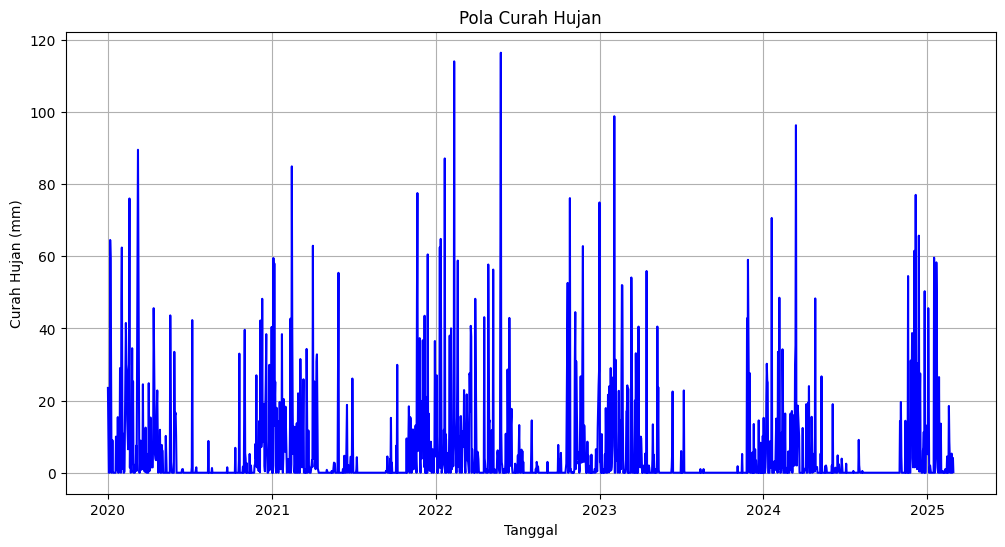

In [17]:
# Visualisasi pola curah hujan
plt.figure(figsize=(12, 6))
plt.plot(time_series_data['TANGGAL'], time_series_data['Curah_Hujan'], color='blue')
plt.xlabel('Tanggal')
plt.ylabel('Curah Hujan (mm)')
plt.title('Pola Curah Hujan')
plt.grid(True)
plt.show()

In [23]:
# Transformasi logaritmik untuk curah hujan (menambah 1 untuk menghindari log(0))
time_series_data['Curah_Hujan_Log'] = np.log1p(time_series_data['Curah_Hujan'])


KeyError: 'Curah_Hujan_Log'

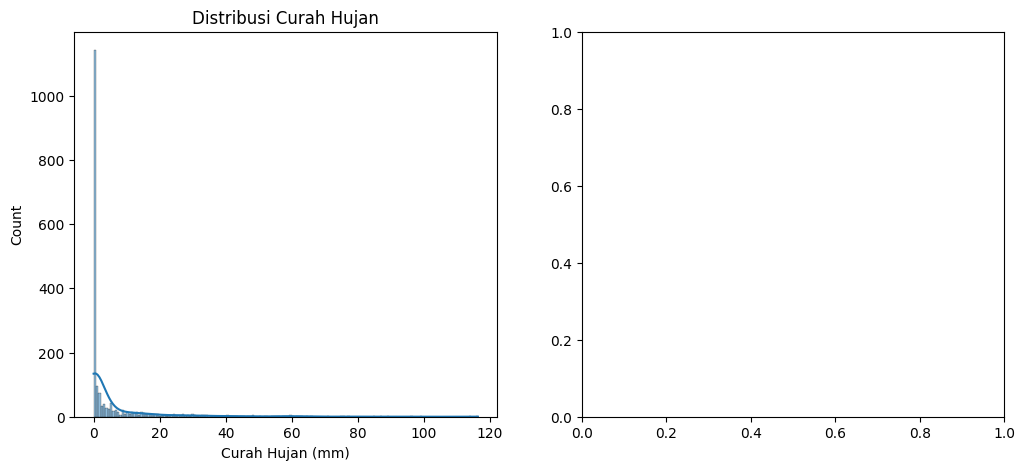

In [18]:
# Visualisasi distribusi curah hujan sebelum dan sesudah transformasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(time_series_data['Curah_Hujan'], kde=True)
plt.title('Distribusi Curah Hujan')
plt.xlabel('Curah Hujan (mm)')

plt.subplot(1, 2, 2)
sns.histplot(time_series_data['Curah_Hujan_Log'], kde=True)
plt.title('Distribusi Curah Hujan (Log Transformed)')
plt.xlabel('Log(Curah Hujan + 1)')
plt.tight_layout()
plt.show()

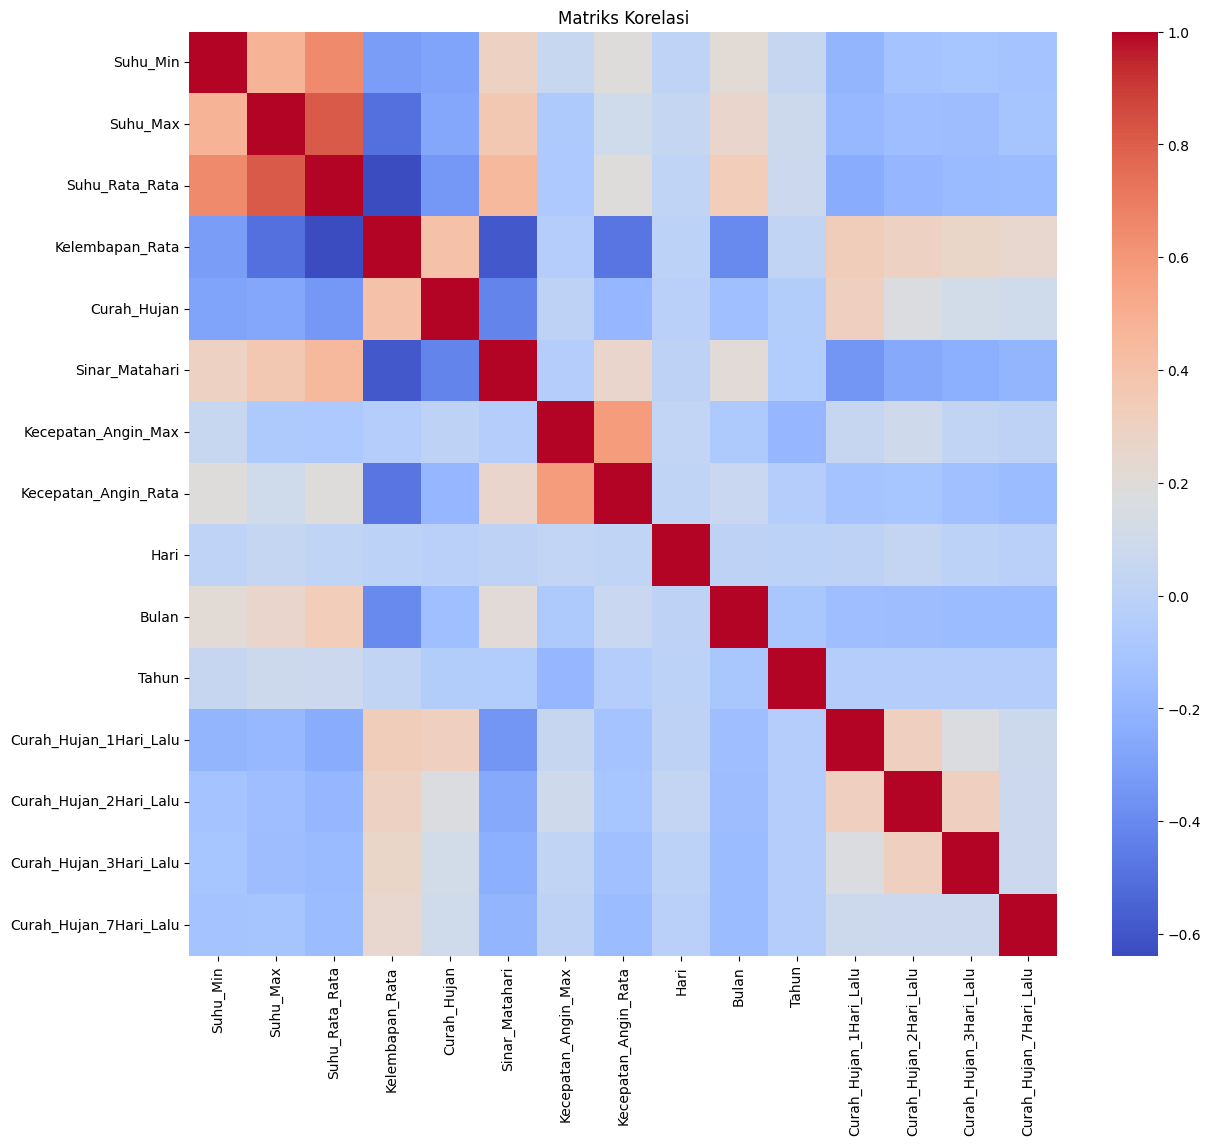

In [19]:
# Analisis korelasi
plt.figure(figsize=(14, 12))
# Memilih hanya kolom numerik
numeric_data = time_series_data.select_dtypes(include=[np.number])
corr = numeric_data.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Matriks Korelasi')
plt.show()


In [20]:
# Cari korelasi terhadap curah hujan
curah_hujan_corr = corr['Curah_Hujan'].sort_values(ascending=False)
print("\nKorelasi Variabel dengan Curah Hujan:")
print(curah_hujan_corr)


Korelasi Variabel dengan Curah Hujan:
Curah_Hujan               1.000000
Kelembapan_Rata           0.401336
Curah_Hujan_1Hari_Lalu    0.308988
Curah_Hujan_2Hari_Lalu    0.162796
Curah_Hujan_3Hari_Lalu    0.112070
Curah_Hujan_7Hari_Lalu    0.102743
Kecepatan_Angin_Max       0.002268
Hari                     -0.015945
Tahun                    -0.044385
Bulan                    -0.141539
Kecepatan_Angin_Rata     -0.183960
Suhu_Max                 -0.271374
Suhu_Min                 -0.281294
Suhu_Rata_Rata           -0.337850
Sinar_Matahari           -0.426725
Name: Curah_Hujan, dtype: float64


In [28]:
# Memilih fitur berdasarkan korelasi dan pengetahuan domain
fitur = [
    'Suhu_Min', 'Suhu_Max', 'Suhu_Rata_Rata', 'Kelembapan_Rata', 
    'Sinar_Matahari', 'Kecepatan_Angin_Max', 'Kecepatan_Angin_Rata',
    'Curah_Hujan_1Hari_Lalu', 'Curah_Hujan_2Hari_Lalu', 'Curah_Hujan_3Hari_Lalu', 'Curah_Hujan_7Hari_Lalu', 'Hari','Bulan', 'Tahun'
]
# Penyiapan data untuk modelisasi
# Memilih antara target asli atau transformasi log
target = 'Curah_Hujan'  # Menggunakan transformasi log

# Memisahkan fitur dan target
X = time_series_data[fitur]
y = time_series_data[target]

In [29]:
# Membagi data menjadi training dan testing set (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nJumlah data training:", X_train.shape[0])
print("Jumlah data testing:", X_test.shape[0])



Jumlah data training: 1509
Jumlah data testing: 378


In [29]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# Agar kolom X_train dan X_test tetap sejajar
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)


In [30]:
# Memilih dan melatih model (Random Forest)
model_rf = RandomForestRegressor(
    n_estimators=200,    # Meningkatkan jumlah pohon
    min_samples_split=10, # Meningkatkan minimum sampel untuk pembagian
    min_samples_leaf=5,  # Meningkatkan minimum sampel di daun
    random_state=42
)

model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

In [31]:
# Evaluasi Random Forest
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)
mape_rf = np.mean(np.abs((y_test - y_pred_rf) / y_test)) * 100
print(f"Random Forest - MAE: {mae_rf:.4f}")
print(f"Random Forest - MSE: {mse_rf:.4f}")
print(f"Random Forest - RMSE: {rmse_rf:.4f}")
print(f"Random Forest - R² Score: {r2_rf:.4f}")
print(f"Random Forest - MAPE: {mape_rf:.4f}%")

Random Forest - MAE: 5.3242
Random Forest - MSE: 109.4852
Random Forest - RMSE: 10.4635
Random Forest - R² Score: 0.2815
Random Forest - MAPE: inf%


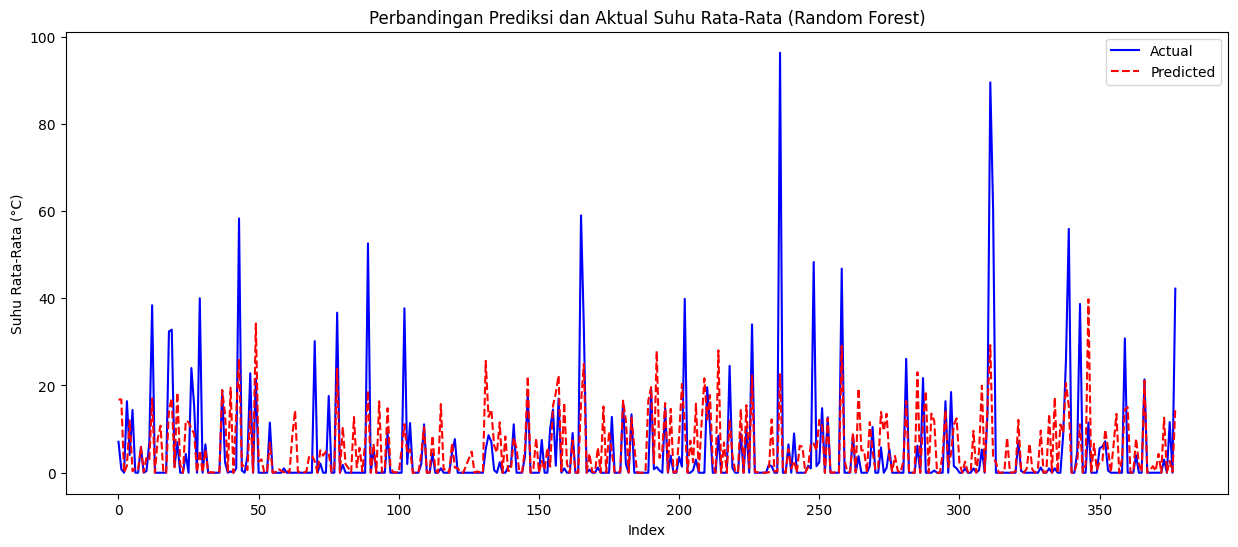

In [32]:
# Visualisasi hasil Random Forest
plt.figure(figsize=(15, 6))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(y_pred_rf, label='Predicted', color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Suhu Rata-Rata (°C)')
plt.title('Perbandingan Prediksi dan Aktual Suhu Rata-Rata (Random Forest)')
plt.legend()
plt.show()